In [9]:
import datetime
import importlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yfinance as yf

In [160]:
ticker = "^GSPC"
interval = "1d"
period = "60d"

df_hf = yf.download(ticker, interval=interval, start="1994-01-01")
df_lf = yf.download(ticker, interval="1mo", start="1994-01-01")
df_lf

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC
Date,,,,,
1994-01-01,481.609985,482.850006,464.359985,466.510010,6627390000
1994-02-01,467.140015,482.230011,464.260010,481.600006,5853100000
1994-03-01,445.769989,471.089996,436.160004,467.190002,7225010000
1994-04-01,450.910004,452.790009,435.859985,445.660004,5735010000
1994-05-01,456.500000,457.769989,440.779999,450.910004,5675970000
...,...,...,...,...,...
2025-03-01,5611.850098,5986.089844,5488.729980,5968.330078,111387270000
2025-04-01,5569.060059,5695.310059,4835.040039,5597.529785,118936380000


In [161]:
prices_hf = df_hf["Close"][ticker].sort_index()
prices_hf = prices_hf[prices_hf>0].dropna()
log_prices_hf = np.log(prices_hf.astype(float))
rets = log_prices_hf.diff().dropna()
rv = (rets**2).resample("MS").sum(min_count=1).dropna()
rv.index = rv.index.tz_localize(None)
rv

Date
1994-01-01    0.000416
1994-02-01    0.001041
1994-03-01    0.000902
1994-04-01    0.001364
1994-05-01    0.000751
                ...   
2025-03-01    0.003561
2025-04-01    0.018926
2025-05-01    0.002335
2025-06-01    0.000859
2025-07-01    0.000228
Freq: MS, Name: ^GSPC, Length: 379, dtype: float64

In [162]:
lf_price = df_lf["Close"][ticker].sort_index()
daily = lf_price.reindex(rv.index, method="ffill")

p = daily.reindex(rv.index, method="ffill")
p = p[p > 0].dropna()
log_p = np.log(p)
log_p = log_p.reindex(rv.index, method="ffill")
dy = log_p.diff()

# scale by sqrt(RV)
eps = 1e-12
omega = np.sqrt(rv + eps)
u = (dy / omega).dropna()

# cumulative; prepend 0 at one-interval-earlier timestamp for stability
if len(u) > 1:
    delta = u.index[1] - u.index[0]
    x0_idx = u.index[0] - delta
    x = pd.concat([pd.Series([0.0], index=[x0_idx]), u.cumsum()])
else:
    x = u.cumsum()

In [163]:
from typing import Optional, List, Tuple

# ================================================================
# 4. Dickey-Fuller t-statistic (right-tailed) on a series
# ================================================================
from statsmodels.tsa.stattools import adfuller

def df_tstat(
    x: pd.Series,
    max_lags: Optional[int] = None,
    autolag: str = "AIC",
    regression: str = "c",
) -> float:
    """
    Run statsmodels ADF regression and return the *t-stat on lagged level* (ρ).

    We use this as a right-tailed detector of explosiveness: large + t => evidence
    that ρ > 0 (explosive).  # BYZ Sec 3 RVPWY test builds on PWY sup DF  :contentReference[oaicite:29]{index=29}
    """
    s = pd.Series(x).dropna()
    if len(s) < 10:
        return np.nan
    res = adfuller(
        s.values,
        maxlag=max_lags,
        regression=regression,
        autolag=autolag,
        store=True,
        regresults=True,
    )
    reg = res[-1].resols  # OLSResults
    try:
        tval = reg.tvalues[1]  # y.L1
    except Exception:
        # fallback parse
        names = list(reg.model.exog_names)
        idx = names.index("y.L1") if "y.L1" in names else 1
        tval = reg.tvalues[idx]
    return float(tval)

# ================================================================
# 5. Recursive RVDF path & RVPWY sup statistic
# ================================================================
def rvdf_path(x: pd.Series, r0: float = 0.1, **df_kw) -> pd.Series:
    """
    For k = ceil(r0*n) ... n:
        compute DF t-stat on x[0:k]
    Return Series indexed by τ = k/n.  # BYZ Sec 3  :contentReference[oaicite:30]{index=30}
    """
    s = pd.Series(x).dropna()
    n = len(s)
    if n == 0:
        return pd.Series(dtype=float, name="RVDF")
    k0 = int(np.ceil(r0 * n))
    stats = []
    taus = []
    for k in range(k0, n + 1):
        stats.append(df_tstat(s.iloc[:k], **df_kw))
        taus.append(k / n)
    return pd.Series(stats, index=pd.Index(taus, name="tau"), name="RVDF")


def rvpwy_stat(x: pd.Series, r0: float = 0.1, **df_kw) -> Tuple[float, pd.Series]:
    """
    Compute RVDF path and its supremum (RVPWY statistic).  # BYZ Thm 2  :contentReference[oaicite:31]{index=31}
    """
    path = rvdf_path(x, r0=r0, **df_kw)
    supstat = np.nanmax(path.values) if len(path) else np.nan
    return supstat, path

In [164]:
r0 = 0.1
stat, path = rvpwy_stat(x, r0=r0)
print("RVPWY stat:", stat)

RVPWY stat: 3.9823651495742185


In [165]:
# ================================================================
# 6. Null critical values by Monte Carlo (optional but useful)
# ================================================================
def simulate_critvals(
    n: int,
    r0: float,
    reps: int = 2000,
    seed: Optional[int] = None,
    **df_kw,
) -> dict:
    """
    Approximate PWY/RVPWY right-tailed null critical values by simulation.

    Generate iid N(0,1) increments, cumulate to RW, compute sup DF each rep.  
    Under BYZ, RVPWY shares PWY null ⇒ このシミュレーションで代用可。  :contentReference[oaicite:32]{index=32}
    """
    rng = np.random.default_rng(seed)
    stats = np.empty(reps)
    for i in range(reps):
        eps = rng.standard_normal(n)
        rw = np.cumsum(eps)
        stat, _ = rvpwy_stat(pd.Series(rw), r0=r0, **df_kw)
        stats[i] = stat
    return {
        "10%": float(np.quantile(stats, 0.90)),
        "5%":  float(np.quantile(stats, 0.95)),
        "1%":  float(np.quantile(stats, 0.99)),
        "dist": stats,
    }


# ================================================================
# 7. Date-stamping (single-episode PWY/BYZ rule)
# ================================================================
def date_stamp(
    rvdf_series: pd.Series,
    crit: float,
    min_separation: Optional[int] = None,
) -> List[Tuple[pd.Timestamp, Optional[pd.Timestamp]]]:
    """
    Identify (start, end) of an explosive episode from RVDF path:

      start = first t where RVDF > crit
      end   = first t >= start + holdoff where RVDF < crit
      holdoff = ceil(log(n)) if min_separation not given

    Repeat to pick up multiple disjoint episodes.  # BYZ dating rule  :contentReference[oaicite:33]{index=33}
    """
    s = rvdf_series.dropna()
    n = len(s)
    if n == 0:
        return []
    if min_separation is None:
        min_separation = int(np.ceil(np.log(max(n, 2))))

    episodes = []
    i = 0
    while i < n:
        if s.iloc[i] > crit:
            start_idx = i
            j = max(i + min_separation, i + 1)
            end_idx = None
            while j < n:
                if s.iloc[j] < crit:
                    end_idx = j
                    break
                j += 1
            start = s.index[start_idx]
            end   = s.index[end_idx] if end_idx is not None else None
            episodes.append((start, end))
            i = j if end_idx is not None else n
        else:
            i += 1
    return episodes

In [166]:
critvals = simulate_critvals(n=len(path), r0=0.1, reps=1000, seed=123)
episodes = date_stamp(path, crit=critvals["5%"])
episodes

[(0.24802110817941952, 0.41424802110817943),
 (0.41688654353562005, 0.43271767810026385),
 (0.44063324538258575, 0.5408970976253298),
 (0.5567282321899736, 0.5725593667546174),
 (0.58311345646438, 0.5989445910290238)]

In [167]:
# ================================================================
# 9. Quick plot helper
# ================================================================
def plot_rvpwy(
    daily_price: pd.Series,
    pseudo: pd.Series,
    rvdf_series: pd.Series,
    critvals: Optional[dict] = None,
):
    """3-panel quicklook plot."""
    fig, axes = plt.subplots(3, 1, figsize=(10, 8), sharex=False)
    # panel 1: log price
    lp = np.log(daily_price[daily_price > 0])
    lp.plot(ax=axes[0], title="Log price")
    # panel 2: pseudo cumulative
    pseudo.plot(ax=axes[1], title="Pseudo (devolatized) series")
    # panel 3: RVDF path
    rvdf_series.plot(ax=axes[2], title="RVDF path (DF t-stat)")
    if critvals is not None:
        for lbl, cv in critvals.items():
            if lbl.endswith("%"):
                axes[2].axhline(cv, ls="--", lw=0.8, label=lbl)
        axes[2].legend()
    fig.tight_layout()
    return fig

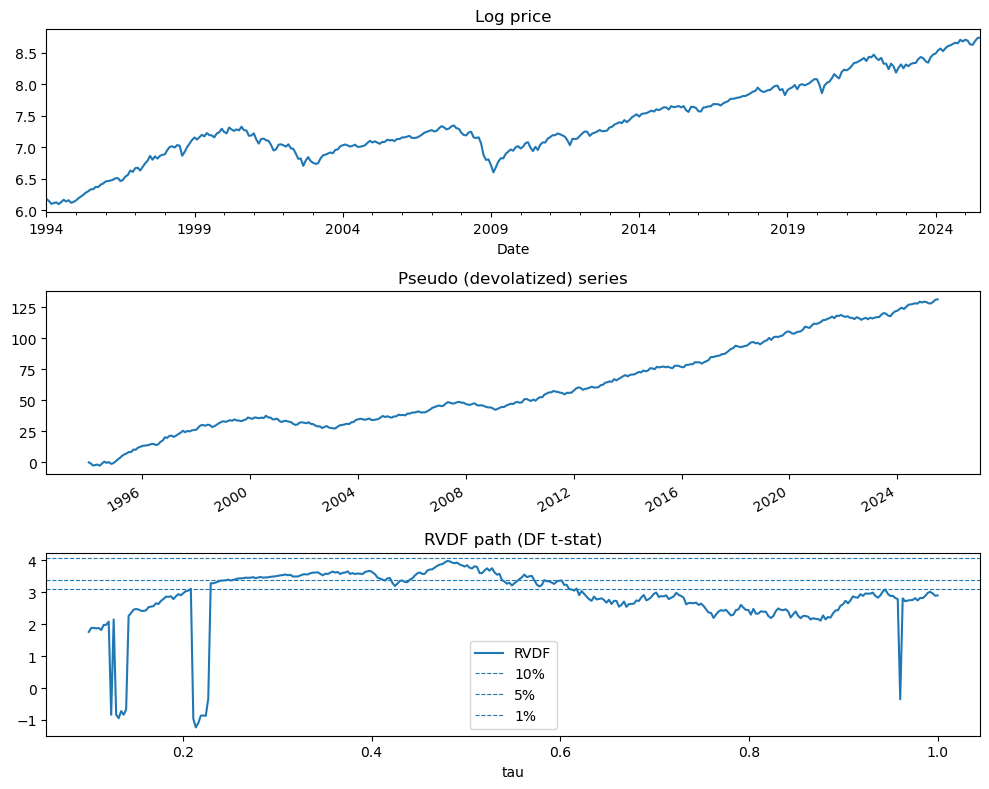

In [168]:
plot_rvpwy(daily, x, path, critvals)
plt.show()